In [34]:
import cv2 
import numpy as np
import os 
from random import shuffle
from tqdm import tqdm 


TRAIN_DIR = 'all/train'
TEST_DIR = 'all/test'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic')


In [35]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return[0,1]

In [36]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data
        

In [37]:
def procces_test_data():
    test_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
        test_data.append([np.array(img), img_num])
    np.save('test_data.npy', test_data)
    return test_data


In [38]:
#train_data = create_train_data()
#if you already have train data:
train_data = np.load('train_data.npy')

100%|██████████| 25000/25000 [07:07<00:00, 58.48it/s]


In [57]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tflearn.datasets.mnist as mnist

import tensorflow as tf
tf.reset_default_graph()


convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir = 'log')

In [58]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model Loaded!.')

INFO:tensorflow:Restoring parameters from /home/arya/Desktop/tensorflow/dogsvscats-0.001-2conv-basic.model
model Loaded!.


In [59]:
train = train_data[:-500]
test = train_data[-500:]

In [60]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]




In [61]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 7659  | total loss: 0.22123 | time: 86.846s
| Adam | epoch: 005 | loss: 0.22123 - acc: 0.9082 -- iter: 24448/24500
Training Step: 7660  | total loss: 0.23472 | time: 88.064s
| Adam | epoch: 005 | loss: 0.23472 - acc: 0.9033 | val_loss: 0.39289 - val_acc: 0.8580 -- iter: 24500/24500
--


In [62]:
model.save(MODEL_NAME)

INFO:tensorflow:/home/arya/Desktop/tensorflow/dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


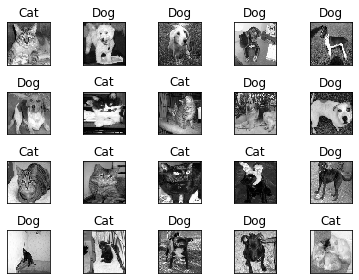

In [63]:
import matplotlib.pyplot as plt

# if you - dont have this file 
#test_data = procces_test_data()
# if you have already save it 
test_data = np.load('test_data.npy')

fig = plt.figure()

for num, data in enumerate(test_data[:20]):
    # cat[1,0]
    # dog[0,1]
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(4, 5, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label = 'Dog'
    
    else: str_label = 'Cat'
    
    y.imshow(orig, cmap = 'gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    plt.tight_layout()

plt.show()

    

In [ ]:
with open('submission-file.csv', 'w') as f:
    f.write('id,label\n')

In [ ]:
with open('submission-file.csv', 'a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
        model_out = model.predict([data])[0]
        f.write('{}, {}\n'.format(img_num,model_out[1]))
        
